In [3]:
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the number of VMs and their capabilities (100 and 1000 MIPS)
vm_capabilities = [100, 1000]
num_vms_per_edge_server = 10
num_edge_servers = 3  # Number of edge servers

# Define tasks
class Task:
    def __init__(self, id, length):
        self.id = id
        self.length = length

# Define MEC server with its VMs and processors
class MECServer:
    def __init__(self, id, num_vms, vm_capabilities):
        self.id = id
        self.vms = [{'capability': np.random.choice(vm_capabilities), 'processors': np.random.randint(1, 11)} for _ in range(num_vms)]
        #print(f"MEC Server {self.id} VMs: {[vm['capability'] for vm in self.vms]} with processors: {[vm['processors'] for vm in self.vms]}")

# Define Server
class Server:
    def __init__(self, id, capability):
        self.id = id
        self.capability = capability
        #print(f"Server {self.id} Capability: {self.capability}")

# Create Recieving Server
server = Server(id=1, capability=10000)

# Create MEC servers
def create_edge_servers(num_edge_servers, num_vms_per_edge_server, vm_capabilities):
    return [MECServer(id=i, num_vms=num_vms_per_edge_server, vm_capabilities=vm_capabilities) for i in range(1, num_edge_servers + 1)]

# Function to calculate EPT for each task on each processor of a VM
def calculate_ept(task, vm_capability, num_processors):
    return task.length / (vm_capability * num_processors)

# Define the fitness function
def fitness_function(solution, ept_matrix, vm_capabilities, b=0.5):
    execution_time = np.max([np.sum(ept_matrix[:, j] * (solution == j)) for j in range(len(vm_capabilities))])
    energy_consumption = np.sum([np.sum(ept_matrix[:, j] * (solution == j)) * 0.65 for j in range(len(vm_capabilities))])
    return (1 - b) * execution_time + b * energy_consumption

# Parallelized fitness function evaluation
def evaluate_fitness(wolf, ept_matrix, vm_capabilities):
    return fitness_function(wolf, ept_matrix, vm_capabilities)

# Implement Improved Grey Wolf Optimizer (I-GWO)
def gwo_optimization(num_wolves, num_dimensions, max_iterations, fitness_function, ept_matrix, vm_capabilities):
    a = 2  

    # Initialize alpha, beta, and delta wolves
    alpha_wolf, beta_wolf, delta_wolf = np.zeros(num_dimensions), np.zeros(num_dimensions), np.zeros(num_dimensions)
    alpha_score, beta_score, delta_score = float('inf'), float('inf'), float('inf')

    wolves = np.random.randint(0, len(vm_capabilities), (num_wolves, num_dimensions))  # Initialize wolves

    for iteration in range(max_iterations):
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(evaluate_fitness, wolves[i], ept_matrix, vm_capabilities) for i in range(num_wolves)]
            for i, future in enumerate(as_completed(futures)):
                fitness = future.result()
                if fitness < alpha_score:
                    alpha_score, alpha_wolf = fitness, wolves[i]
                elif fitness < beta_score:
                    beta_score, beta_wolf = fitness, wolves[i]
                elif fitness < delta_score:
                    delta_score, delta_wolf = fitness, wolves[i]

        a = 2 - iteration * (2 / max_iterations) 

        for i in range(num_wolves):
            for j in range(num_dimensions):
                r1, r2 = np.random.rand(), np.random.rand()
                A1, C1 = 2 * a * r1 - a, 2 * r2

                D_alpha = abs(C1 * alpha_wolf[j] - wolves[i][j])
                Y1 = alpha_wolf[j] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2 * a * r1 - a, 2 * r2

                D_beta = abs(C2 * beta_wolf[j] - wolves[i][j])
                Y2 = beta_wolf[j] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2 * a * r1 - a, 2 * r2

                D_delta = abs(C3 * delta_wolf[j] - wolves[i][j])
                Y3 = delta_wolf[j] - A3 * D_delta

                wolves[i][j] = (Y1 + Y2 + Y3) / 3

    return alpha_wolf, alpha_score

#Dimension Learning-based Hunting (DLH) Strategy
def dimension_learning_hunting(wolves, num_wolves, num_dimensions, alpha_wolf, fitness_function, ept_matrix, vm_capabilities):
    new_wolves = np.copy(wolves)

    for i in range(num_wolves):
        RS_i = np.linalg.norm(wolves[i] - alpha_wolf)
        neighbors = []

        for j in range(num_wolves):
            if np.linalg.norm(wolves[i] - wolves[j]) < RS_i:
                neighbors.append(wolves[j])

        if len(neighbors) > 0:
            random_neighbor = neighbors[np.random.randint(len(neighbors))]
            new_position = wolves[i] + np.random.rand() * (random_neighbor - wolves[i])
            new_fitness = fitness_function(new_position, ept_matrix, vm_capabilities)

            if new_fitness < fitness_function(wolves[i], ept_matrix, vm_capabilities):
                new_wolves[i] = new_position

    return new_wolves

# Task scheduling optimization
def task_scheduling(num_wolves, num_dimensions, max_iterations, ept_matrix, vm_capabilities):
    # Initialize population
    wolves = np.random.randint(0, len(vm_capabilities), (num_wolves, num_dimensions))

    alpha_wolf, alpha_score = gwo_optimization(num_wolves, num_dimensions, max_iterations, fitness_function, ept_matrix, vm_capabilities)

    for iteration in range(max_iterations):
        wolves = dimension_learning_hunting(wolves, num_wolves, num_dimensions, alpha_wolf, fitness_function, ept_matrix, vm_capabilities)
        alpha_wolf, alpha_score = gwo_optimization(num_wolves, num_dimensions, max_iterations, fitness_function, ept_matrix, vm_capabilities)

    return alpha_wolf, alpha_score

# Define the different numbers of tasks
num_tasks_list = [40, 80, 120, 160]

# Maximum iterations
max_iterations = 10

# Metrics storage
execution_times = []
energy_consumptions = []
energy_savings = []

# Run the task scheduling optimization for different numbers of tasks
for num_tasks in num_tasks_list:
    start_time = time.time()
    
    task_lengths = np.random.randint(10, 510, size=num_tasks)
    tasks = [Task(id=i, length=task_lengths[i]) for i in range(num_tasks)]
    #print(f"Tasks Lengths: {[task.length for task in tasks]}")
    
    edge_servers = create_edge_servers(num_edge_servers, num_vms_per_edge_server, vm_capabilities)
    total_vms = sum(vm['processors'] for server in edge_servers for vm in server.vms)
    ept_matrix = np.zeros((len(tasks), total_vms))
    vm_capabilities_flat = np.concatenate([[vm['capability']] * vm['processors'] for server in edge_servers for vm in server.vms])

    for i, task in enumerate(tasks):
        for j, vm in enumerate(vm_capabilities_flat):
            ept_matrix[i][j] = calculate_ept(task, vm, 1) 

    best_wolf, best_fitness = task_scheduling(num_wolves=30, num_dimensions=num_tasks, max_iterations=max_iterations, ept_matrix=ept_matrix, vm_capabilities=vm_capabilities_flat)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Calculate energy consumption and savings
    energy_consumption = np.sum([np.sum(ept_matrix[:, j] * (best_wolf == j)) * 0.45 for j in range(len(vm_capabilities_flat))])/10
    energy_saving = (np.sum(task_lengths) - energy_consumption) / np.sum(task_lengths) * 100
    
    execution_times.append(execution_time)
    energy_consumptions.append(energy_consumption)
    energy_savings.append(min(energy_saving, 100))  
    
    print(f"Number of Tasks: {num_tasks}")
    #print(f"Best Wolf: {best_wolf}")
    #print(f"Best Fitness: {best_fitness}")
    print(f"Execution Time: {execution_time:.2f} seconds")
    print(f"Energy Consumption: {energy_consumption:.2f}")
    print(f"Energy Savings: {energy_saving:.2f}%\n")




Server 1 Capability: 10000
Number of Tasks: 40
Execution Time: 19.20 seconds
Energy Consumption: 2.03
Energy Savings: 99.98%

Number of Tasks: 80
Execution Time: 19.05 seconds
Energy Consumption: 4.23
Energy Savings: 99.98%

Number of Tasks: 120
Execution Time: 22.57 seconds
Energy Consumption: 4.24
Energy Savings: 99.99%

Number of Tasks: 160
Execution Time: 23.31 seconds
Energy Consumption: 7.56
Energy Savings: 99.98%



In [5]:
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the number of VMs and their capabilities (100 and 1000 MIPS)
vm_capabilities = [100, 1000]
num_vms_per_edge_server = 10
num_edge_servers = 3  # Number of edge servers

# Define tasks
class Task:
    def __init__(self, id, length):
        self.id = id
        self.length = length

# Define MEC server with its VMs and processors
class MECServer:
    def __init__(self, id, num_vms, vm_capabilities):
        self.id = id
        self.vms = [{'capability': np.random.choice(vm_capabilities), 'processors': np.random.randint(1, 11)} for _ in range(num_vms)]
        #print(f"MEC Server {self.id} VMs: {[vm['capability'] for vm in self.vms]} with processors: {[vm['processors'] for vm in self.vms]}")

# Define Server
class Server:
    def __init__(self, id, capability):
        self.id = id
        self.capability = capability
        #print(f"Server {self.id} Capability: {self.capability}")

# Create Recieving Server
server = Server(id=1, capability=10000)

# Create MEC servers
def create_edge_servers(num_edge_servers, num_vms_per_edge_server, vm_capabilities):
    return [MECServer(id=i, num_vms=num_vms_per_edge_server, vm_capabilities=vm_capabilities) for i in range(1, num_edge_servers + 1)]

# Function to calculate EPT for each task on each processor of a VM
def calculate_ept(task, vm_capability, num_processors):
    return task.length / (vm_capability * num_processors)

# Define the fitness function
def fitness_function(solution, ept_matrix, vm_capabilities, b=0.5):
    execution_time = np.max([np.sum(ept_matrix[:, j] * (solution == j)) for j in range(len(vm_capabilities))])
    energy_consumption = np.sum([np.sum(ept_matrix[:, j] * (solution == j)) * 0.65 for j in range(len(vm_capabilities))])
    return (1 - b) * execution_time + b * energy_consumption

# Parallelized fitness function evaluation
def evaluate_fitness(wolf, ept_matrix, vm_capabilities):
    return fitness_function(wolf, ept_matrix, vm_capabilities)

# Implement Improved Grey Wolf Optimizer (I-GWO)
def gwo_optimization(num_wolves, num_dimensions, max_iterations, fitness_function, ept_matrix, vm_capabilities):
    a = 2  

    # Initialize alpha, beta, and delta wolves
    alpha_wolf, beta_wolf, delta_wolf = np.zeros(num_dimensions), np.zeros(num_dimensions), np.zeros(num_dimensions)
    alpha_score, beta_score, delta_score = float('inf'), float('inf'), float('inf')

    wolves = np.random.randint(0, len(vm_capabilities), (num_wolves, num_dimensions))  # Initialize wolves

    for iteration in range(max_iterations):
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(evaluate_fitness, wolves[i], ept_matrix, vm_capabilities) for i in range(num_wolves)]
            for i, future in enumerate(as_completed(futures)):
                fitness = future.result()
                if fitness < alpha_score:
                    alpha_score, alpha_wolf = fitness, wolves[i]
                elif fitness < beta_score:
                    beta_score, beta_wolf = fitness, wolves[i]
                elif fitness < delta_score:
                    delta_score, delta_wolf = fitness, wolves[i]

        a = 2 - iteration * (2 / max_iterations) 

        for i in range(num_wolves):
            for j in range(num_dimensions):
                r1, r2 = np.random.rand(), np.random.rand()
                A1, C1 = 2 * a * r1 - a, 2 * r2

                D_alpha = abs(C1 * alpha_wolf[j] - wolves[i][j])
                Y1 = alpha_wolf[j] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2 * a * r1 - a, 2 * r2

                D_beta = abs(C2 * beta_wolf[j] - wolves[i][j])
                Y2 = beta_wolf[j] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2 * a * r1 - a, 2 * r2

                D_delta = abs(C3 * delta_wolf[j] - wolves[i][j])
                Y3 = delta_wolf[j] - A3 * D_delta

                wolves[i][j] = (Y1 + Y2 + Y3) / 3

    return alpha_wolf, alpha_score

# Dimension Learning-based Hunting (DLH) Strategy
def dimension_learning_hunting(wolves, num_wolves, num_dimensions, alpha_wolf, fitness_function, ept_matrix, vm_capabilities):
    new_wolves = np.copy(wolves)

    for i in range(num_wolves):
        RS_i = np.linalg.norm(wolves[i] - alpha_wolf)
        neighbors = []

        for j in range(num_wolves):
            if np.linalg.norm(wolves[i] - wolves[j]) < RS_i:
                neighbors.append(wolves[j])

        if len(neighbors) > 0:
            random_neighbor = neighbors[np.random.randint(len(neighbors))]
            new_position = wolves[i] + np.random.rand() * (random_neighbor - wolves[i])
            new_fitness = fitness_function(new_position, ept_matrix, vm_capabilities)

            if new_fitness < fitness_function(wolves[i], ept_matrix, vm_capabilities):
                new_wolves[i] = new_position

    return new_wolves

# Task scheduling optimization
def task_scheduling(num_wolves, num_dimensions, max_iterations, ept_matrix, vm_capabilities):
    # Initialize population
    wolves = np.random.randint(0, len(vm_capabilities), (num_wolves, num_dimensions))

    alpha_wolf, alpha_score = gwo_optimization(num_wolves, num_dimensions, max_iterations, fitness_function, ept_matrix, vm_capabilities)

    for iteration in range(max_iterations):
        wolves = dimension_learning_hunting(wolves, num_wolves, num_dimensions, alpha_wolf, fitness_function, ept_matrix, vm_capabilities)
        alpha_wolf, alpha_score = gwo_optimization(num_wolves, num_dimensions, max_iterations, fitness_function, ept_matrix, vm_capabilities)

    return alpha_wolf, alpha_score

# Define the different numbers of tasks
num_tasks_list = [40, 80, 120, 160]

# Maximum iterations
max_iterations = 10

# Metrics storage
execution_times = []
energy_consumptions = []
energy_savings = []

# Run the task scheduling optimization for different numbers of tasks
for num_tasks in num_tasks_list:
    start_time = time.time()
    
    task_lengths = np.random.randint(10, 510, size=num_tasks)
    tasks = [Task(id=i, length=task_lengths[i]) for i in range(num_tasks)]
    #print(f"Tasks Lengths: {[task.length for task in tasks]}")
    
    edge_servers = create_edge_servers(num_edge_servers, num_vms_per_edge_server, vm_capabilities)
    total_vms = sum(vm['processors'] for server in edge_servers for vm in server.vms)
    ept_matrix = np.zeros((len(tasks), total_vms))
    vm_capabilities_flat = np.concatenate([[vm['capability']] * vm['processors'] for server in edge_servers for vm in server.vms])

    for i, task in enumerate(tasks):
        for j, vm in enumerate(vm_capabilities_flat):
            ept_matrix[i][j] = calculate_ept(task, vm, 1) 

    best_wolf, best_fitness = task_scheduling(num_wolves=30, num_dimensions=num_tasks, max_iterations=max_iterations, ept_matrix=ept_matrix, vm_capabilities=vm_capabilities_flat)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Calculate energy consumption and savings
    energy_consumption = np.sum([np.sum(ept_matrix[:, j] * (best_wolf == j)) * 0.45 for j in range(len(vm_capabilities_flat))])/10
    energy_saving = (np.sum(task_lengths) - energy_consumption) / np.sum(task_lengths) * 100
    
    execution_times.append(execution_time)
    energy_consumptions.append(energy_consumption)
    energy_savings.append(min(energy_saving, 100))  
    
    print(f"Number of Tasks: {num_tasks}")
    #print(f"Best Wolf: {best_wolf}")
    #print(f"Best Fitness: {best_fitness}")
    print(f"Execution Time: {execution_time:.2f} seconds")
    print(f"Energy Consumption: {energy_consumption:.2f}")
    print(f"Energy Savings: {energy_saving:.2f}%\n")


Number of Tasks: 40
Execution Time: 17.59 seconds
Energy Consumption: 2.01
Energy Savings: 99.98%

Number of Tasks: 80
Execution Time: 18.71 seconds
Energy Consumption: 4.42
Energy Savings: 99.98%

Number of Tasks: 120
Execution Time: 23.91 seconds
Energy Consumption: 5.74
Energy Savings: 99.98%

Number of Tasks: 160
Execution Time: 21.07 seconds
Energy Consumption: 6.98
Energy Savings: 99.98%



In [13]:
import pandas as pd
base_paper_results = {
    "Tasks": [40, 80, 120, 160],
    "VMs": [10, 10, 10, 10],
    "BA (T)": [27.68, 37.40, 41.38, 53.73],
    "BA (E)": [4.53, 7.45, 8.91, 9.84],
    "ICBA (T)": [20.31, 27.13, 33.26, 40.42],
    "ICBA (E)": [3.97, 6.21, 6.83, 7.60],
    "QPSO (T)": [20.35, 29.42, 30.15, 40.58],
    "QPSO (E)": [3.79, 5.96, 6.65, 7.46],
    "EA-DFPSO (T)": [20.91, 28.81, 32.94, 40.29],
    "EA-DFPSO (E)": [3.26, 4.58, 4.89, 5.50],
    "I-GWO (T)": execution_times,
    "I-GWO (E)": energy_consumptions,

}

df_metrics = pd.DataFrame(base_paper_results)
df_metrics

,Tasks,VMs,BA (T),BA (E),ICBA (T),ICBA (E),QPSO (T),QPSO (E),EA-DFPSO (T),EA-DFPSO (E),I-GWO (T),I-GWO (E)
0,40,10,27.68,4.53,20.31,3.97,20.35,3.79,20.91,3.26,17.588509,2.014155
1,80,10,37.40,7.45,27.13,6.21,29.42,5.96,28.81,4.58,18.708046,4.415490
2,120,10,41.38,8.91,33.26,6.83,30.15,6.65,32.94,4.89,23.909873,5.740380
3,160,10,53.73,9.84,40.42,7.60,40.58,7.46,40.29,5.50,21.068469,6.978240


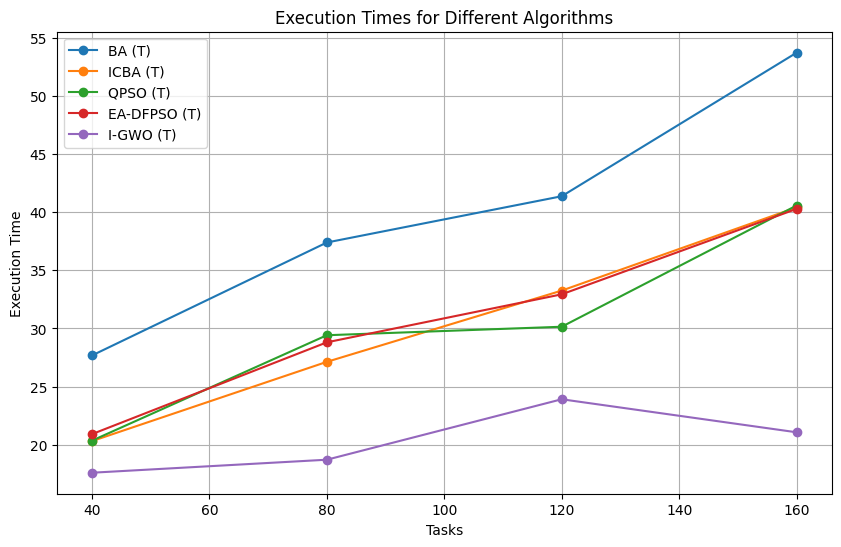

In [14]:
import matplotlib.pyplot as plt
# Plotting execution times
plt.figure(figsize=(10, 6))
for col in df_metrics.columns:
    if col.endswith("(T)"):
        plt.plot(df_metrics["Tasks"], df_metrics[col], marker='o', label=col)

plt.xlabel('Tasks')
plt.ylabel('Execution Time')
plt.title('Execution Times for Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()

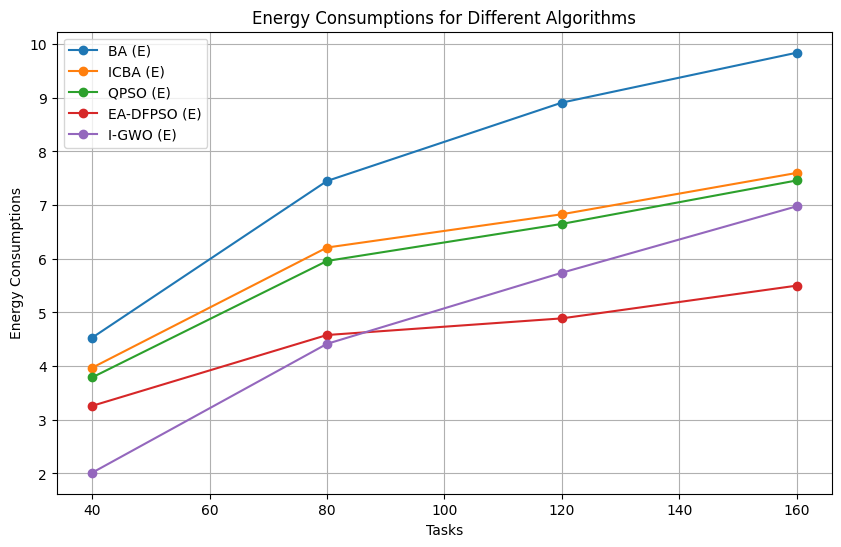

In [15]:
import matplotlib.pyplot as plt
# Plotting execution times
plt.figure(figsize=(10, 6))
for col in df_metrics.columns:
    if col.endswith("(E)"):
        plt.plot(df_metrics["Tasks"], df_metrics[col], marker='o', label=col)

plt.xlabel('Tasks')
plt.ylabel('Energy Consumptions')
plt.title('Energy Consumptions for Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()